# Creating dataframes to obtain data points required to create KPIs.

## Total Number of Recipes and Total Number of Unique Recipes.

In [1]:
reset -fs

In [2]:
import seaborn as sns
import datalab.bigquery as bq
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import re
%matplotlib inline

### To view all full columns of any dataframe, not truncated, we set the option below:

In [3]:
pd.set_option('display.max_colwidth', -1)

### Getting the count of recipe URLs that have been scrapped from different websites.

In [4]:
%%sql --module num_urls
SELECT url, COUNT(url) as num_urls
FROM [firebase-wellio:recipes.recipes]
GROUP BY url
ORDER BY num_urls DESC

In [5]:
%%bigquery execute -q num_urls

url,num_urls
http://www.food.com/recipe/watermelon-salad-229886,1
http://www.food.com/recipe/easy-chicken-dumplings-264279,1
http://www.food.com/recipe/lisas-chocolate-coconut-macaroons-313303,1
http://www.food.com/recipe/red-passion-colada-319551,1
http://www.food.com/recipe/creepy-graveyard-cake-494752,1
http://www.food.com/recipe/athenian-pasta-primavera-383028,1
http://www.food.com/recipe/margarita-chicken-484837,1
http://www.food.com/recipe/julia-child-braised-garlic-cloves-simmered-in-cream-108744,1
http://www.food.com/recipe/chocolate-eclair-pie-355000,1
http://www.food.com/recipe/christmas-cupcakes-148834,1


### Getting the URLs domain count for all recipes.

In [6]:
%%sql --module recipes_sites_data
SELECT SUBSTRING(url, 1, INSTR(url, '.com')+4) as domain_url, COUNT(substring(url, 1, INSTR(url, '.com')+4)) as domain_count
FROM [firebase-wellio:recipes.recipes]
WHERE url IS NOT NULL
GROUP BY domain_url
ORDER BY domain_count DESC

In [7]:
%%bigquery execute -q recipes_sites_data

domain_url,domain_count
http://www.food.com/,388402
http://www.epicurious.com/,95949
http://allrecipes.com/,37765
http://www.myrecipes.com/,18214
http://www.foodnetwork.com/,5459
http://www.seriouseats.com/,4664
http://www.thekitchn.com/,252
http://cooking.nytimes.com/,17
http://www.bonappetit.com/,4
http,2


### Converting BigQuery into a pandas dataframe.

In [8]:
recipes_sites_df = bq.Query(recipes_sites_data).to_dataframe()

In [9]:
# To avoid:
# /usr/local/lib/python2.7/dist-packages/seaborn/categorical.py:1424: FutureWarning: remove_na is deprecated and is a private function. Do not use.
# stat_data = remove_na(group_data)
# When printing below chart.
warnings.filterwarnings('ignore')

### Plotting above dataframe.

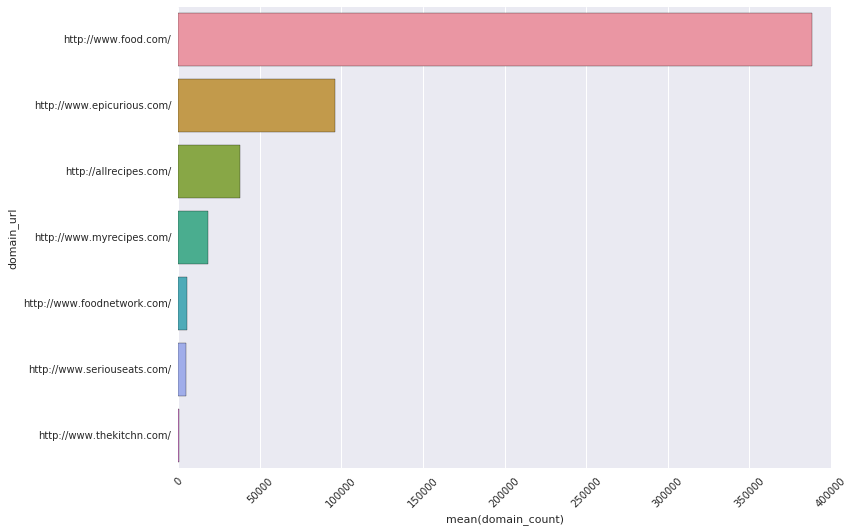

In [10]:
sns.set_style("whitegrid")
# Set the plot size in inches.
sns.set(rc={'figure.figsize':(11.7,8.27)})
recipes_plot = sns.barplot(x='domain_count', y='domain_url', data=recipes_sites_df[:7])
plt.setp(recipes_plot.get_xticklabels(), rotation=45);

### We create a new dataframe from the 1st one and dropping a column.

In [11]:
all_recipes_sites_df = bq.Query(num_urls).to_dataframe()

In [12]:
all_recipes_sites_df.drop('num_urls', axis=1, inplace=True)

In [13]:
all_recipes_sites_df.head()

,url
0,http://www.food.com/recipe/watermelon-salad-229886
1,http://www.food.com/recipe/easy-chicken-dumplings-264279
2,http://www.food.com/recipe/lisas-chocolate-coconut-macaroons-313303
3,http://www.food.com/recipe/red-passion-colada-319551
4,http://www.food.com/recipe/creepy-graveyard-cake-494752


In [14]:
all_recipes_df = all_recipes_sites_df

In [15]:
all_recipes_df.rename(columns = {'url':'full_recipe_url'}, inplace=True)

In [16]:
all_recipes_df.head()

,full_recipe_url
0,http://www.food.com/recipe/watermelon-salad-229886
1,http://www.food.com/recipe/easy-chicken-dumplings-264279
2,http://www.food.com/recipe/lisas-chocolate-coconut-macaroons-313303
3,http://www.food.com/recipe/red-passion-colada-319551
4,http://www.food.com/recipe/creepy-graveyard-cake-494752


In [17]:
def find_index_char(my_dataframe_element, my_character):
  '''
  This function returns a substring. We provide a column from a dataframe, represented by variable my_dataframe_element,
  and we find all the index positions of a character (represented by variable my_character) in such element.
  This will create a list of all the indices of such character (if more than 1 is found) in the dataframe element, which is 
  represented by the variable list_of_positions. If we want to return the last position of such character, we would return 
  list_of_positions[-1]
  In this case, we will return the sliced element starting at the last index position of the provided character we are interested.
  The unique recipe is at the end of every url, i.e. http://www.food.com/recipe/watermelon-salad-229886, the recipe is watermelon-salad-229886.
  '''
  list_of_positions = [pos for pos, char in enumerate(my_dataframe_element) if char == my_character]
  return my_dataframe_element[list_of_positions[-1]:]

In [18]:
def find_index_char_hard_coded(my_dataframe_element):
  '''
  This function returns a substring. We provide a column from a dataframe, represented by variable my_dataframe_element,
  and we find all the index positions of a hardcoded character (which is / in this case) in such element.
  This will create a list of all the indices of such character (if more than 1 is found) in the dataframe element, which is 
  represented by the variable list_of_positions. If we want to return the last position of such character, we would return 
  list_of_positions[-1]
  In this case, we will return the sliced element starting at the last index position of the provided character we are interested.
  '''
  list_of_positions = [pos for pos, char in enumerate(my_dataframe_element) if char == '/']
  return my_dataframe_element[list_of_positions[-1]:]

#### Example of applying above function to the 1st row of the new dataframe. We are interesting in the string after the last '/' as it will be the unique identifier for each recipe.

In [19]:
all_recipes_df.iloc[0]

full_recipe_url    http://www.food.com/recipe/watermelon-salad-229886
Name: 0, dtype: object

In [20]:
find_index_char(all_recipes_df.iloc[0].to_string(), '/')

u'/watermelon-salad-229886'

### Now we create a new column in the dataframe to store the identifier of each recipe.

In [21]:
all_recipes_df['recipe']=''

In [22]:
all_recipes_df.head()

,full_recipe_url,recipe
0,http://www.food.com/recipe/watermelon-salad-229886,
1,http://www.food.com/recipe/easy-chicken-dumplings-264279,
2,http://www.food.com/recipe/lisas-chocolate-coconut-macaroons-313303,
3,http://www.food.com/recipe/red-passion-colada-319551,
4,http://www.food.com/recipe/creepy-graveyard-cake-494752,


### We apply the function to 5 rows to see if it works.

In [23]:
all_recipes_df['recipe'] = all_recipes_df['full_recipe_url'][:5].apply(find_index_char_hard_coded)

In [24]:
all_recipes_df.head()

,full_recipe_url,recipe
0,http://www.food.com/recipe/watermelon-salad-229886,/watermelon-salad-229886
1,http://www.food.com/recipe/easy-chicken-dumplings-264279,/easy-chicken-dumplings-264279
2,http://www.food.com/recipe/lisas-chocolate-coconut-macaroons-313303,/lisas-chocolate-coconut-macaroons-313303
3,http://www.food.com/recipe/red-passion-colada-319551,/red-passion-colada-319551
4,http://www.food.com/recipe/creepy-graveyard-cake-494752,/creepy-graveyard-cake-494752


### Since the function works, we apply it to the entire dataframe column.

In [25]:
all_recipes_df['recipe'] = all_recipes_df['full_recipe_url'].apply(find_index_char_hard_coded)

In [26]:
all_recipes_df.tail()

,full_recipe_url,recipe
550738,http://www.food.com/recipe/sausage-and-summer-squash-311007,/sausage-and-summer-squash-311007
550739,http://www.food.com/recipe/butter-chicken-curry-229228,/butter-chicken-curry-229228
550740,http://www.food.com/recipe/lightened-up-lemon-chicken-velvet-soup-293353,/lightened-up-lemon-chicken-velvet-soup-293353
550741,http://www.food.com/recipe/rum-flambeed-strawberries-364395,/rum-flambeed-strawberries-364395
550742,http://www.food.com/recipe/mandarin-spinach-bowl-130684,/mandarin-spinach-bowl-130684


In [27]:
all_recipes_df.shape

(550743, 2)

### Do we have duplicated recipes?

In [28]:
all_recipes_df.drop_duplicates().shape

(550743, 2)

#### There are no duplicated recipes.

### Let's use a different table.

In [29]:
%%sql --module imported_urls
SELECT COUNT(url) AS count_urls
FROM [firebase-wellio:recipes.imported_recipes]
WHERE url IS NOT NULL

In [30]:
%%bigquery execute -q imported_urls

count_urls
8301786


In [31]:
%%sql --module imported_recipes
SELECT url, COUNT(url) AS count_urls
FROM [firebase-wellio:recipes.imported_recipes]
WHERE url IS NOT NULL AND url <> '#'
GROUP BY url
ORDER BY count_urls DESC
-- We limit the number of records since when we export this query to a dataframe, the notebook can't handle 8 million rows.
LIMIT 1000

In [32]:
%%bigquery execute -q imported_recipes

url,count_urls
https://www.duncanhines.com/recipes/brownies/jilltaylor86/red-velvet-fudge-brownies/,13980
http://www.thegreenlife.ca/fr/salade-cremeuse-au-kale-peches-grillees-croutons-epices/,12882
http://www.thegreenlife.ca/mexican-chocolate-avocado-mousse-workshop-recap/,11646
http://www.thegreenlife.ca/fr/chocolat-chaud-red-velvet/,11555
http://www.motherthyme.com/2014/08/bread-pudding.html?utm_source=feedburner&utm_medium=email&utm_campaign=Feed:+motherthyme/BYjd+(Mother+Thyme),11286
http://www.thegreenlife.ca/raw-eggnog-bliss-balls/,11260
https://www.tillamook.com/recipes/monster-muenster-panini.html,11081
http://www.thegreenlife.ca/fr/frites-de-patates-douces-sauce-au-tahini-et-aux-herbes/,11009
http://www.thegreenlife.ca/fr/barres-de-millet-souffle-tahini-sesame-et-figues/,10767
http://www.thegreenlife.ca/almond-cherry-cacao-nib-breakfast-cookies/,10436


#### There's a final '/' in some URLs that should be removed.

In [33]:
%%sql --module imported_recipes_no_final_slash
SELECT url,
CASE
  WHEN RIGHT(url, 1) = '/' THEN LEFT(url, LENGTH(url)-1)
  ELSE url
END
FROM [firebase-wellio:recipes.imported_recipes]
WHERE url IS NOT NULL AND url <> '#'
LIMIT 50

In [34]:
%%bigquery execute -q imported_recipes_no_final_slash

url,f0_
http://fromaway.com/cooking/chicken-piccata-sandwiches-with-garlicky-spinach-on-garlic-bread,http://fromaway.com/cooking/chicken-piccata-sandwiches-with-garlicky-spinach-on-garlic-bread
http://www.feedyoursoul2.com/2017/05/asparagus-tater-tot-frittata.html,http://www.feedyoursoul2.com/2017/05/asparagus-tater-tot-frittata.html
http://www.diettaste.com/soups/beef-barley-soup.html,http://www.diettaste.com/soups/beef-barley-soup.html
http://www.food.com/recipe/crock-pot-beef-chili-493613,http://www.food.com/recipe/crock-pot-beef-chili-493613
https://happykitchen.rocks/spelt-whole-grain-bread/,https://happykitchen.rocks/spelt-whole-grain-bread
http://www.prevention.com/recipes/buttermilk-and-blueberry-pancakes,http://www.prevention.com/recipes/buttermilk-and-blueberry-pancakes
http://www.food.com/recipe/green-salsa-chicken-43057,http://www.food.com/recipe/green-salsa-chicken-43057
http://www.food.com/recipe/cream-of-wheat-to-die-for-520029,http://www.food.com/recipe/cream-of-wheat-to-die-for-520029
http://www.aheadofthyme.com/2015/12/lentil-stew-with-carrots-and-potatoes/,http://www.aheadofthyme.com/2015/12/lentil-stew-with-carrots-and-potatoes
http://relish.com/recipes/chicken-and-daikon-salad/,http://relish.com/recipes/chicken-and-daikon-salad


### Unfortunately, when we try to run above for the entire table, we get:

#### `HTTP request failed: Response too large to return. Consider setting allowLargeResults to true in your job configuration. For more information, see https://cloud.google.com/bigquery/troubleshooting-errors`

### So we need to export into a pandas dataframe and handle it there.

In [35]:
imported_recipes_sites_df = bq.Query(imported_recipes).to_dataframe()

In [36]:
del imported_recipes_sites_df['count_urls']

In [37]:
imported_recipes_sites_df.head()

,url
0,https://www.duncanhines.com/recipes/brownies/jilltaylor86/red-velvet-fudge-brownies/
1,http://www.thegreenlife.ca/fr/salade-cremeuse-au-kale-peches-grillees-croutons-epices/
2,http://www.thegreenlife.ca/mexican-chocolate-avocado-mousse-workshop-recap/
3,http://www.thegreenlife.ca/fr/chocolat-chaud-red-velvet/
4,http://www.motherthyme.com/2014/08/bread-pudding.html?utm_source=feedburner&utm_medium=email&utm_campaign=Feed:+motherthyme/BYjd+(Mother+Thyme)


In [38]:
imported_recipes_sites_df.shape

(1000, 1)

In [39]:
imported_recipes_sites_df.drop_duplicates().shape

(1000, 1)

### Removing final '/' in URL if present:

In [40]:
def remove_final_slash(my_dataframe_series):
  '''
  Some URLs contain a final /, so we remove it if present.
  '''
  if my_dataframe_series[-1] == '/':
    final_series = my_dataframe_series[0:len(my_dataframe_series)-1]
  else:
    final_series = my_dataframe_series
  return final_series

In [41]:
imported_recipes_sites_df['recipe'] = imported_recipes_sites_df['url'][:5].apply(remove_final_slash)

In [42]:
imported_recipes_sites_df.head()

,url,recipe
0,https://www.duncanhines.com/recipes/brownies/jilltaylor86/red-velvet-fudge-brownies/,https://www.duncanhines.com/recipes/brownies/jilltaylor86/red-velvet-fudge-brownies
1,http://www.thegreenlife.ca/fr/salade-cremeuse-au-kale-peches-grillees-croutons-epices/,http://www.thegreenlife.ca/fr/salade-cremeuse-au-kale-peches-grillees-croutons-epices
2,http://www.thegreenlife.ca/mexican-chocolate-avocado-mousse-workshop-recap/,http://www.thegreenlife.ca/mexican-chocolate-avocado-mousse-workshop-recap
3,http://www.thegreenlife.ca/fr/chocolat-chaud-red-velvet/,http://www.thegreenlife.ca/fr/chocolat-chaud-red-velvet
4,http://www.motherthyme.com/2014/08/bread-pudding.html?utm_source=feedburner&utm_medium=email&utm_campaign=Feed:+motherthyme/BYjd+(Mother+Thyme),http://www.motherthyme.com/2014/08/bread-pudding.html?utm_source=feedburner&utm_medium=email&utm_campaign=Feed:+motherthyme/BYjd+(Mother+Thyme)


In [43]:
imported_recipes_sites_df['recipe'] = imported_recipes_sites_df['url'].apply(remove_final_slash)

In [44]:
imported_recipes_sites_df.tail()

,url,recipe
995,http://preventionrd.com/2017/06/peanut-sesame-noodles-with-chicken-and-veggies/,http://preventionrd.com/2017/06/peanut-sesame-noodles-with-chicken-and-veggies
996,http://thegirlonbloor.com/lemongrass-steak-noodle-bowls/,http://thegirlonbloor.com/lemongrass-steak-noodle-bowls
997,http://allrecipes.com/recipe/76129/spinach-tomato-tortellini/,http://allrecipes.com/recipe/76129/spinach-tomato-tortellini
998,http://www.food.com/recipe/italian-lemon-cauliflower-79873,http://www.food.com/recipe/italian-lemon-cauliflower-79873
999,http://www.food.com/recipe/chicken-risotto-soup-213266,http://www.food.com/recipe/chicken-risotto-soup-213266


### If there's an URL which contains some Google Ad code, we remove it. For example:
### `http://www.motherthyme.com/2014/08/bread-pudding.html?utm_source=feedburner&utm_medium=email&utm_campaign=Feed:+motherthyme/BYjd+(Mother+Thyme`

In [45]:
def remove_utm(my_dataframe_series):
  '''
  This function removes Google Ad Words code from the URL, which is identified by ?utm_source= if present.
  '''
  if '?utm_source=' in my_dataframe_series:
    utm_index = my_dataframe_series.index('?utm_source=')
    final_series = my_dataframe_series[0:utm_index]
  else:
    final_series = my_dataframe_series
  return final_series

In [46]:
imported_recipes_sites_df['recipe'] = imported_recipes_sites_df['recipe'].apply(remove_utm)

In [47]:
imported_recipes_sites_df['final_recipe'] = imported_recipes_sites_df['recipe'].apply(find_index_char_hard_coded)

In [48]:
imported_recipes_sites_df.tail()

,url,recipe,final_recipe
995,http://preventionrd.com/2017/06/peanut-sesame-noodles-with-chicken-and-veggies/,http://preventionrd.com/2017/06/peanut-sesame-noodles-with-chicken-and-veggies,/peanut-sesame-noodles-with-chicken-and-veggies
996,http://thegirlonbloor.com/lemongrass-steak-noodle-bowls/,http://thegirlonbloor.com/lemongrass-steak-noodle-bowls,/lemongrass-steak-noodle-bowls
997,http://allrecipes.com/recipe/76129/spinach-tomato-tortellini/,http://allrecipes.com/recipe/76129/spinach-tomato-tortellini,/spinach-tomato-tortellini
998,http://www.food.com/recipe/italian-lemon-cauliflower-79873,http://www.food.com/recipe/italian-lemon-cauliflower-79873,/italian-lemon-cauliflower-79873
999,http://www.food.com/recipe/chicken-risotto-soup-213266,http://www.food.com/recipe/chicken-risotto-soup-213266,/chicken-risotto-soup-213266


### We have different domains: .com, .ca...

In [49]:
def find_index_char_hard_coded_first(my_dataframe_element):
  '''
  This function returns a substring. We provide a column from a dataframe, represented by variable my_dataframe_element,
  and we find all the index positions of a hardcoded character (which is / in this case) in such element.
  This will create a list of all the indices of such character (if more than 1 is found) in the dataframe element, which is 
  represented by the variable list_of_positions. If we want to return the first position of such character, we would return 
  list_of_positions[0]
  In this case, we will return the sliced element starting at the first index position of the provided character we are interested.
  '''
  list_of_positions = [pos for pos, char in enumerate(my_dataframe_element) if char == '/']
  if 'http' or 'https' in my_dataframe_element:
    return my_dataframe_element[0:list_of_positions[2]]

In [50]:
imported_recipes_sites_df['recipe_domain'] = imported_recipes_sites_df['url'].apply(find_index_char_hard_coded_first)

In [51]:
imported_recipes_sites_df.head()

,url,recipe,final_recipe,recipe_domain
0,https://www.duncanhines.com/recipes/brownies/jilltaylor86/red-velvet-fudge-brownies/,https://www.duncanhines.com/recipes/brownies/jilltaylor86/red-velvet-fudge-brownies,/red-velvet-fudge-brownies,https://www.duncanhines.com
1,http://www.thegreenlife.ca/fr/salade-cremeuse-au-kale-peches-grillees-croutons-epices/,http://www.thegreenlife.ca/fr/salade-cremeuse-au-kale-peches-grillees-croutons-epices,/salade-cremeuse-au-kale-peches-grillees-croutons-epices,http://www.thegreenlife.ca
2,http://www.thegreenlife.ca/mexican-chocolate-avocado-mousse-workshop-recap/,http://www.thegreenlife.ca/mexican-chocolate-avocado-mousse-workshop-recap,/mexican-chocolate-avocado-mousse-workshop-recap,http://www.thegreenlife.ca
3,http://www.thegreenlife.ca/fr/chocolat-chaud-red-velvet/,http://www.thegreenlife.ca/fr/chocolat-chaud-red-velvet,/chocolat-chaud-red-velvet,http://www.thegreenlife.ca
4,http://www.motherthyme.com/2014/08/bread-pudding.html?utm_source=feedburner&utm_medium=email&utm_campaign=Feed:+motherthyme/BYjd+(Mother+Thyme),http://www.motherthyme.com/2014/08/bread-pudding.html,/bread-pudding.html,http://www.motherthyme.com


In [52]:
imported_recipes_sites_df.tail()

,url,recipe,final_recipe,recipe_domain
995,http://preventionrd.com/2017/06/peanut-sesame-noodles-with-chicken-and-veggies/,http://preventionrd.com/2017/06/peanut-sesame-noodles-with-chicken-and-veggies,/peanut-sesame-noodles-with-chicken-and-veggies,http://preventionrd.com
996,http://thegirlonbloor.com/lemongrass-steak-noodle-bowls/,http://thegirlonbloor.com/lemongrass-steak-noodle-bowls,/lemongrass-steak-noodle-bowls,http://thegirlonbloor.com
997,http://allrecipes.com/recipe/76129/spinach-tomato-tortellini/,http://allrecipes.com/recipe/76129/spinach-tomato-tortellini,/spinach-tomato-tortellini,http://allrecipes.com
998,http://www.food.com/recipe/italian-lemon-cauliflower-79873,http://www.food.com/recipe/italian-lemon-cauliflower-79873,/italian-lemon-cauliflower-79873,http://www.food.com
999,http://www.food.com/recipe/chicken-risotto-soup-213266,http://www.food.com/recipe/chicken-risotto-soup-213266,/chicken-risotto-soup-213266,http://www.food.com


In [53]:
imported_recipes_sites_df['recipe_domain'].value_counts()

http://www.thegreenlife.ca                192
http://www.myrecipes.com                  57 
https://www.budgetbytes.com               35 
https://www.tillamook.com                 34 
http://www.taste.com.au                   25 
https://www.duncanhines.com               18 
http://www.food.com                       17 
http://crockpotladies.com                 16 
http://www.lifemadedelicious.ca           14 
http://myrecipemagic.com                  13 
https://duncanhines.com                   11 
http://allrecipes.com                     11 
http://theinspiredhome.org                10 
http://www.foodnetwork.com                9  
http://www.prevention.com                 9  
http://damndelicious.net                  8  
http://www.primalpalate.com               8  
https://cooking.nytimes.com               8  
http://thegirlonbloor.com                 7  
http://www.seriouseats.com                5  
http://www.tasteandtellblog.com           5  
http://carlsbadcravings.com       

### We create a dataframe to store all URL domains and their counts.

In [54]:
domains_df = imported_recipes_sites_df['recipe_domain'].value_counts().to_frame()

In [55]:
domains_df.head()

,recipe_domain
http://www.thegreenlife.ca,192
http://www.myrecipes.com,57
https://www.budgetbytes.com,35
https://www.tillamook.com,34
http://www.taste.com.au,25


In [56]:
domains_df.reset_index(inplace=True)

In [57]:
domains_df.rename(columns = {'index':'domain', 'recipe_domain':'domain_count'}, inplace=True)

In [58]:
domains_df.head()

,domain,domain_count
0,http://www.thegreenlife.ca,192
1,http://www.myrecipes.com,57
2,https://www.budgetbytes.com,35
3,https://www.tillamook.com,34
4,http://www.taste.com.au,25


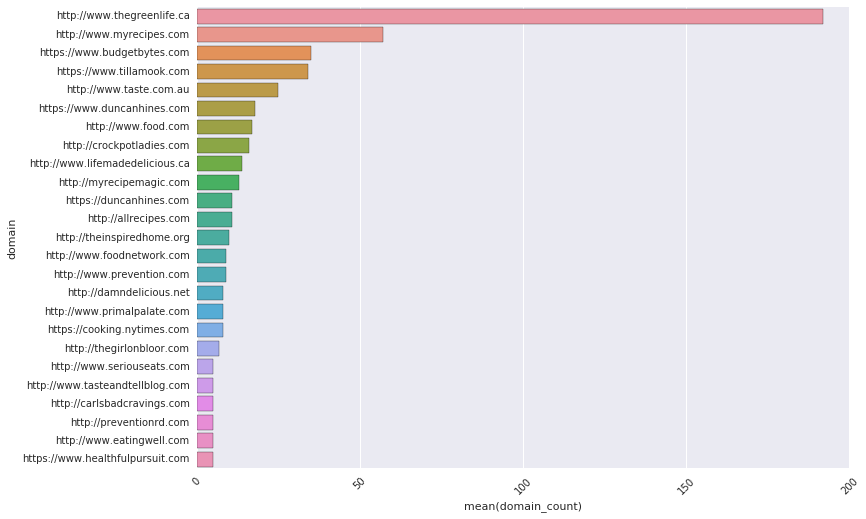

In [59]:
url_recipes_plot = sns.barplot(x='domain_count', y='domain', data=domains_df[:25])
plt.setp(url_recipes_plot.get_xticklabels(), rotation=45);